![](../images/FE_04.png)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pyspark.sql import SparkSession

# Đọc dữ liệu

In [3]:
spark = SparkSession.builder.appName("Manh Cuong dep trai vo dich sieu cap vu tru").getOrCreate()

In [4]:
data = spark.read.csv("../data/cbc-news-coronavirus-articles-march-26/news.csv", inferSchema=True, header=True)

In [5]:
data.show(5)

+---+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|_c0|             authors|               title|       publish_date|         description|                text|                 url|
+---+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|  0|        ['Cbc News']|Coronavirus a 'wa...|2020-03-27 08:00:00|Canadian pharmaci...|"Canadian pharmac...|"" he said.  Tadr...|
|  1|        ['Cbc News']|Yukon gov't names...|2020-03-27 01:45:00|The Yukon governm...|"The Yukon govern...|  from March 9 to 13|
|  2|['The Associated ...|U.S. Senate passe...|2020-03-26 05:13:00|The Senate has pa...|"The Senate late ...|"" said Democrati...|
|  3|        ['Cbc News']|Coronavirus: The ...|2020-03-27 00:36:00|Scientists around...|"Scientists aroun...| "" said Zarychanski|
|  4|        ['Cbc News']|The latest on the...|2020-03-26 20:57:00|The latest on th

In [6]:
data.count()

3566

In [7]:
data = data.dropDuplicates()

In [8]:
from modules.utils import dropEmptyCell, formatTextFeature
# dropEmptyCell(pDf: pyspark.sql.DataFrame, pFeatures: List[str]):

In [9]:
data = dropEmptyCell(data, ['description', 'text'])

In [10]:
data.count()

3566

+----+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
| _c0|             authors|               title|       publish_date|         description|                text|                 url|
+----+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
| 369|        ['Cbc News']|No confirmed coro...|2020-03-13 15:58:00|The Windsor-Essex...|"The Windsor-Esse...|"" said Colucci. ...|
|1282|                  []|Canada negotiates...|2020-01-30 20:24:00|The federal gover...|"The federal gove...|   getting the names|
|1649|['Reporter Editor...|Hamilton Olympian...|2020-03-25 20:00:00|Kia Nurse, 24, is...|"Kia Nurse has be...|               anger|
|1835|                  []|Here's what to ex...|2020-03-25 08:00:00|As Ontario reels ...|"As Ontario reels...|"" Phillips told ...|
|1982|                  []|Domestic violence...|2020-03-25 09:30:00|A shorta

In [11]:
data = formatTextFeature(data, ['description', 'text'])

In [12]:
from pyspark.ml.feature import VectorAssembler

In [13]:
assembler = VectorAssembler(inputCols=['description_idf', 'text_idf'], outputCol='features')

In [14]:
data = assembler.transform(data)

In [15]:
data.show(3)

+----+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| _c0|             authors|               title|       publish_date|         description|                text|                 url|     description_tok|     description_stp|     description_cvt|     description_idf|            text_tok|            text_stp|            text_cvt|            text_idf|            features|
+----+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 369|        ['Cbc News']|No confirm

In [16]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [17]:
k_list = []
sil_list = []
evaluator = ClusteringEvaluator()
list_model = []

for k in range(2, 7):
    kmeans = KMeans(featuresCol='features', k=k)
    model = kmeans.fit(data)
    predictions = model.transform(data)
    sil = evaluator.evaluate(predictions)
    k_list.append(k)
    sil_list.append(sil)
    list_model.append(model)
    print(f'--> With k = {k} then silhouette with squared euclidean distance  = {sil}')

--> With k = 2 then silhouette with squared euclidean distance  = 0.7025786045950495
--> With k = 3 then silhouette with squared euclidean distance  = 0.6893307742148366
--> With k = 4 then silhouette with squared euclidean distance  = 0.6857964936693404
--> With k = 5 then silhouette with squared euclidean distance  = 0.6830771629763863
--> With k = 6 then silhouette with squared euclidean distance  = 0.4702758143831901


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

def line(a: pd.Series, b: pd.Series, title=""):
    plt.plot(a, b, 'co-')
    plt.xlabel(a.name, color='b', weight='bold')
    plt.ylabel(b.name, color='b', weight='bold')
    plt.title(title, fontsize=18, color='r', weight='bold')
    
    plt.show()

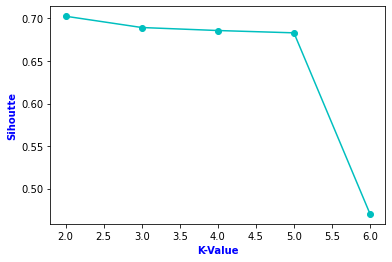

In [19]:
line(pd.Series(k_list, name='K-Value'), pd.Series(sil_list, name='Sihoutte'))

> * Chọn k là 3

In [29]:
predictions = list_model[3 - 2].transform(data)

In [30]:
predictions.show()

+----+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| _c0|             authors|               title|       publish_date|         description|                text|                 url|     description_tok|     description_stp|     description_cvt|     description_idf|            text_tok|            text_stp|            text_cvt|            text_idf|            features|prediction|
+----+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| 36

In [31]:
tmp = predictions.select('prediction', 'description_stp', 'text_stp').collect()

In [32]:
from modules.utils import genWordCloud

In [35]:
wcs = genWordCloud(tmp, 3)

In [36]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

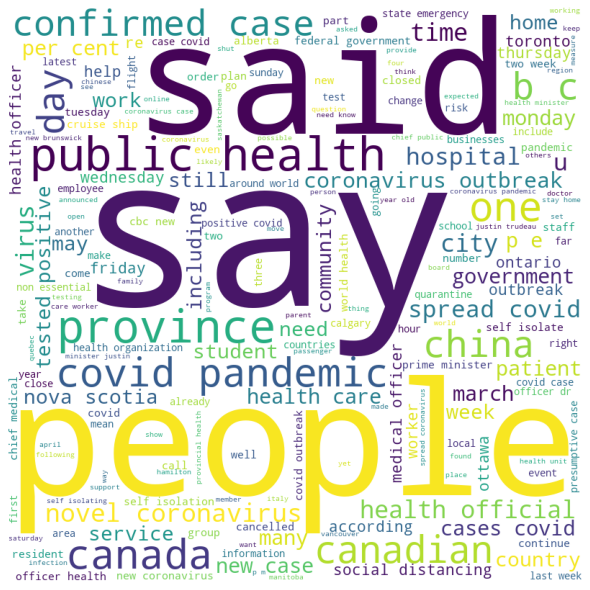

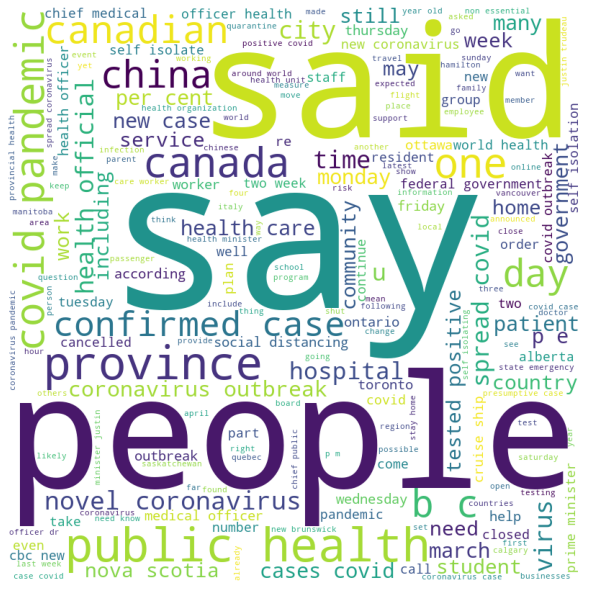

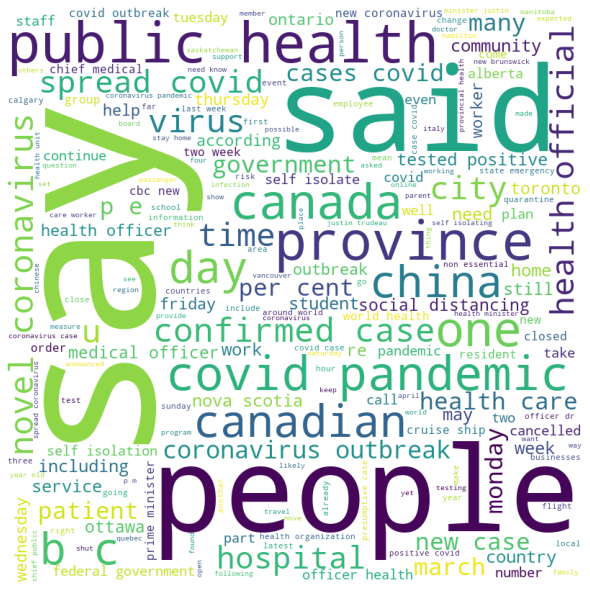

In [37]:
for tmp in wcs:    
    sen = " ".join(tmp)
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(sen)
    
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()

> **Nhận xét**
> * Nhìn chung dù đã áp dụng tf-idf để phân lớp nhưng giữa các lớp vẫn chưa khác biệt to lớn, và vì tập dữ liệu này bẩm sinh đã nói đến vấn đề covid 19 nên về các từ của các lớp đa phần trùng nhau.